In [1]:
%load_ext autoreload
%autoreload 2
from config import *

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Desktop/lgcpspatial/python/notebooks/hyperparameter_fits/


[50,52](2.26e+01,2.56e-01) loss=-9.415828e+03(done)
(P,V)= (22.299706, 0.25600615)
[50,49](2.26e+01,2.94e-01) loss=-9.377485e+03                         (done)
(P,V,θ)= (22.299706, 0.29393438, 0.24434609527920614)


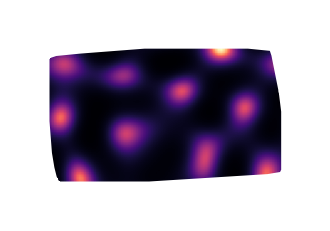

In [2]:
L  = 128
fn   = 'r2405_051216b_cell1816.mat'
data = Dataset.from_file(datadir+fn).prepare(L)

# Prepare hyperparameter grid
Po = data.P # Initial guess for kernel period
Vo = data.V # Initial guess for kernel height 
rp = 2   # Range (ratio) to search for optimal period
rv = 10  # Range (ratio) to search for optimal kernel height
rw = 100 # Range (ratio) to search for optimal white noise
Np = 101 # Period grid resolution
Nv = 101 # Kernel height grid resolution
Nθ = 60  # Angles to test
Ps = float32(exp(linspace(log(Po/rp),log(Po*rp),Np)))
Vs = float32(exp(linspace(log(Vo/rv),log(Vo*rv),Nv))[::-1])
θs = linspace(0,pi/3,Nθ+1)[:Nθ]

# Initial inference ignoring orientation
NKμ = (data.N,data.K,data.prior_mean)
def gcloss(pars, state):
    kf = kernelft(data.shape,*pars)
    return lgcp2d(kf,*NKμ,initial_guess=state)[0]
P,V = grid_search([Ps,Vs],gcloss).pars
print('(P,V)=',(P,V))

# Angle
def angle_helper(θi):
    kernel = kernelft(data.shape,P=P,V=V,style='grid',angle=θi)
    return lgcp2d(kernel,*NKμ)[0]
results = parmap(angle_helper,θs)
allzv, nll, λv = zip(*results)
i = argmax(nll)
θ = θs[i]

# Repeat inference respecting orientation
Po,Vo = P,V
def gcloss2(pars, state):
    kf = kernelft(data.shape,*pars,style='grid',angle=θ)
    return lgcp2d(kf,*NKμ,initial_guess=state)[0]
P,V = grid_search([Ps,Vs],gcloss2).pars
print('(P,V,θ)=',(P,V,θ))

kf = kernelft(data.shape,P=P,V=V,style='grid',angle=θ)
data.arena.imshow(lgcp2d(kf,*NKμ)[0].info.r,lw=8)

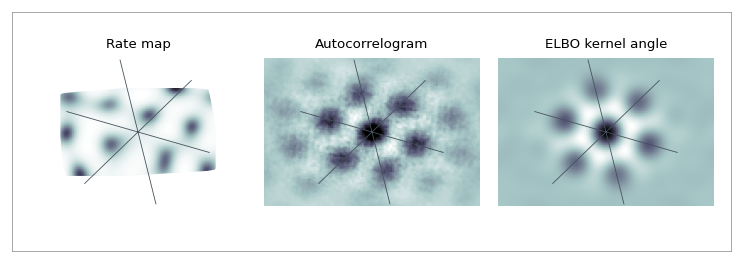

In [3]:
kernel = kernelft(data.shape,P=P,V=V,style='grid',angle=θ)
result = lgcp2d(kernel,data.N,data.K,data.prior_mean)[0]
arena  = data.arena
figure(0,(6,2),120,facecolor='w')
def addorientation(θ):
    xl = data.arena.extent[:2]
    yl = data.arena.extent[2:]
    xm = mean(xl)
    ym = mean(yl)
    r  = min(diff(yl),diff(xl))*0.5
    q0 = conj(exp(1j*(θ+pi/6)))*r
    points = array([q0,exp(1j*pi/3)*q0,exp(-1j*pi/3)*q0])
    q = array([-points,points,NaN*points]).T.ravel() + (xm+ym*1j)
    plot(*c2p(q),lw=.5)
subplot(131)
arena.imshow(result.info.r*data.position_sample_rate,cmap='bone_r')
title('Rate map')
addorientation(θ)
subplot(132)
a = fft_acorr(data.Y)
arena.imshow(a,domask=False,cmap='bone_r',vmax=percentile(a,99.5))
title('Autocorrelogram')
addorientation(θ)
subplot(133)
arena.imshow(fftshift(ifft2(
     kernelft(data.shape,P=P,V=V,style='grid',angle=θ)
    ).real),domask=False,cmap='bone_r')
title('ELBO kernel angle')
addorientation(θ)
tight_layout()
figurebox()